Alec Dayupay - 211831 - C 

Trisha Millena - 214031 - C

Lance Santuyo - 215335 - C

Tonito Sayo - 204647 - C


We hereby attest to the truth of the following facts:

We have not discussed the Python code in my program with anyone
other than my instructor or the teaching assistants assigned to this course.

We have not used Python code obtained from another student, or
any other unauthorized source, whether modified or unmodified.

If any Python code or documentation used in my program was
obtained from another source, it has been clearly noted with citations in the
comments of my program.

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Scikit-learn Modules
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Optional: Advanced Models & Interpretation
try:
    import xgboost as xgb
    from xgboost import XGBRegressor
    HAS_XGB = True
except ImportError:
    HAS_XGB = False
    print("XGBoost not available. Skipping XGBoost models.")

try:
    import lightgbm as lgb
    from lightgbm import LGBMRegressor
    HAS_LGBM = True
except ImportError:
    HAS_LGBM = False
    print("LightGBM not available. Skipping LightGBM models.")

try:
    import shap
    HAS_SHAP = True
    shap.initjs() # Initialize Javascript for SHAP plots in notebooks
except ImportError:
    HAS_SHAP = False
    print("SHAP not available. Skipping SHAP analyses.")

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
random_state = 42 # for reproducibility


___
# Load and Prepare Data
Loading the data cleaned in `preprocessing.py`. This dataset contains only 'Released' movies with non-zero values for key financial and engagement metrics.

In [2]:
df = pd.read_csv("output/cleaned_movie_released_nonzero.csv", index_col=None)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10464 entries, 0 to 10463
Data columns (total 52 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   title                                          10464 non-null  object 
 1   vote_average                                   10464 non-null  float64
 2   vote_count                                     10464 non-null  int64  
 3   status                                         10464 non-null  object 
 4   release_date                                   10343 non-null  object 
 5   revenue                                        10464 non-null  int64  
 6   runtime                                        10464 non-null  int64  
 7   adult                                          10464 non-null  int64  
 8   budget                                         10464 non-null  int64  
 9   original_language                              104

In [3]:
df

,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,budget,original_language,original_title,overview,popularity,keywords,release_year,release_quarter,release_season,release_month,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,...,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Science_Fiction,genre_TV_Movie,genre_Thriller,genre_War,genre_Western,production_companies_Warner_Bros._Pictures,production_companies_BBC,production_companies_Evil_Angel,production_companies_Columbia_Pictures,production_companies_Metro-Goldwyn-Mayer,production_countries_United_States_of_America,production_countries_France,production_countries_Japan,production_countries_Germany,production_countries_United_Kingdom,spoken_languages_English,spoken_languages_French,spoken_languages_Spanish,spoken_languages_Japanese,spoken_languages_German
0,Inception,8.364,34495,Released,2010-07-15,825532764,148,0,160000000,en,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,"rescue, mission, dream, airplane, paris, franc...",2010,3,Summer,7,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,1,0,1,0
1,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,0,165000000,en,Interstellar,The adventures of a group of explorers who mak...,140.241,"rescue, future, spacecraft, race against time,...",2014,4,Fall,11,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0
2,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,0,185000000,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,"joker, sadism, chaos, secret identity, crime f...",2008,3,Summer,7,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0
3,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,0,237000000,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,"future, society, culture clash, space travel, ...",2009,4,Winter,12,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0
4,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,0,220000000,en,The Avengers,When an unexpected enemy emerges and threatens...,98.082,"new york city, superhero, shield, based on com...",2012,2,Spring,4,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10459,Room Zero,10.000,1,Released,2009-02-17,11,52,0,10,en,Room Zero,Wayne Adam Ford is a convicted serial killer o...,0.600,"serial killer, docudrama, educational",2009,1,Winter,2,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10460,Auto Shop of Horrors,10.000,1,Released,2016-10-26,4300,86,0,1200,en,Auto Shop of Horrors,"A mentally disturbed car mechanic, with a deep...",0.643,"dark comedy, parody, horror spoof",2016,4,Fall,10,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
10461,Full Grown Men,6.000,1,Released,2006-04-27,13716,78,0,2000000,en,Full Grown Men,A man stuck in the reveries of his youth track...,1.474,"mermaid, road trip, amusement park, childhood ...",2006,2,Spring,4,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
10462,Khooni Panja,5.000,1,Released,1991-01-01,500000,130,0,100000,hi,Khooni Panja,Seema is murdered by her husband and her hand ...,1.001,NaN,1991,1,Winter,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


___
# Data Cleaning & Filtering 

In [4]:
# Drop rows where release_date is null (should have been handled, but double-check)
df = df.dropna(subset=['release_date']).reset_index(drop=True)

# Ensure runtime is reasonable (e.g., >= 15 minutes)
df = df[(df['runtime'] >= 15) & (df['runtime'] < 400)].reset_index(drop=True)

In [5]:
# Address Potential Data Entry Errors (Budget/Revenue Scale) 
# Filter out entries where budget or revenue seems unrealistically low (e.g., < 1000)
# or where the ratio between them is extremely large, suggesting unit errors.
min_value_threshold = 1000
max_scale_mismatch = 10000

filtered_check = df[["title", "revenue", "budget"]].copy()
filtered_check['scale_mismatch'] = (df['revenue'] / df['budget']).fillna(0).replace(np.inf, 0)
# Handle cases where budget > revenue
filtered_check['scale_mismatch'] = filtered_check['scale_mismatch'].apply(lambda x: x if x >= 1 else (1/x if x > 0 else 0))

to_drop_indices = df[
    (df['revenue'] < min_value_threshold) |
    (df['budget'] < min_value_threshold) |
    (filtered_check['scale_mismatch'] >= max_scale_mismatch)
].index

In [6]:
if not to_drop_indices.empty:
    print(f"Dropping {len(to_drop_indices)} entries due to potential budget/revenue data errors.")
    print("Examples being dropped:")
    print(df.loc[to_drop_indices, ['title', 'budget', 'revenue']].head())
    df = df.drop(index=to_drop_indices).reset_index(drop=True)

Dropping 309 entries due to potential budget/revenue data errors.
Examples being dropped:
                                             title   budget  revenue
4075      French Fried Vacation 3: Friends Forever       35       84
5070                                   Housesitter       26       94
5260                                 Cross of Iron  6000000      201
5654                                         Ben X  1500000       27
5669  City Slickers II: The Legend of Curly's Gold       40       43


___
# Feature Engineering

In [7]:
# Calculate Return on Investment (ROI)
# Using a small epsilon to avoid division by zero if budget is somehow still 0
epsilon = 1
df['roi'] = (df['revenue'] - df['budget']) / (df['budget'] + epsilon)

In [8]:
# Genre count
genre_cols = [col for col in df.columns if col.startswith('genre_')]
df['genre_count'] = df[genre_cols].sum(axis=1)

In [9]:
all_seasons = df['release_season'].unique()
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
season_encoded = encoder.fit_transform(df[['release_season']])

In [10]:
# Create column names for the encoded features
season_cols = [f'season_{season}' for season in encoder.categories_[0]]

# Add encoded columns to dataframe
season_df = pd.DataFrame(season_encoded, columns=season_cols, index=df.index)
df = pd.concat([df, season_df], axis=1)

In [11]:
df.head()

,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,budget,original_language,original_title,overview,popularity,keywords,release_year,release_quarter,release_season,release_month,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,...,genre_TV_Movie,genre_Thriller,genre_War,genre_Western,production_companies_Warner_Bros._Pictures,production_companies_BBC,production_companies_Evil_Angel,production_companies_Columbia_Pictures,production_companies_Metro-Goldwyn-Mayer,production_countries_United_States_of_America,production_countries_France,production_countries_Japan,production_countries_Germany,production_countries_United_Kingdom,spoken_languages_English,spoken_languages_French,spoken_languages_Spanish,spoken_languages_Japanese,spoken_languages_German,roi,genre_count,season_Fall,season_Spring,season_Summer,season_Winter
0,Inception,8.364,34495,Released,2010-07-15,825532764,148,0,160000000,en,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,"rescue, mission, dream, airplane, paris, franc...",2010,3,Summer,7,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,1,0,1,0,4.159580,3,0.0,0.0,1.0,0.0
1,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,0,165000000,en,Interstellar,The adventures of a group of explorers who mak...,140.241,"rescue, future, spacecraft, race against time,...",2014,4,Fall,11,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,3.252904,3,1.0,0.0,0.0,0.0
2,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,0,185000000,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,"joker, sadism, chaos, secret identity, crime f...",2008,3,Summer,7,1,0,0,0,1,0,1,...,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,4.430046,4,0.0,0.0,1.0,0.0
3,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,0,237000000,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,"future, society, culture clash, space travel, ...",2009,4,Winter,12,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,11.336312,4,0.0,0.0,0.0,1.0
4,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,0,220000000,en,The Avengers,When an unexpected enemy emerges and threatens...,98.082,"new york city, superhero, shield, based on com...",2012,2,Spring,4,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,5.903707,3,0.0,1.0,0.0,0.0


# ## 2. Exploratory Data Analysis (EDA) & Preprocessing for Modeling

# Analyze distributions and correlations to understand data properties and inform modeling choices.

In [12]:
# Define Column Groups
numerical_cols_raw = ['budget', 'revenue', 'runtime', 'vote_average', 'vote_count', 'popularity', 'roi', 'genre_count']
categorical_cols = []
encoded_genre_cols = [col for col in df.columns if col.startswith('genre_')]
encoded_genre_cols.remove('genre_count')
encoded_other_cols = [col for col in df.columns if col.startswith(('production_companies_', 'production_countries_', 'spoken_languages_', 'season_'))]
time_features = ['release_year', 'release_quarter', 'release_month'] # genre_count is numerical

In [13]:
encoded_other_cols

['production_companies_Warner_Bros._Pictures',
 'production_companies_BBC',
 'production_companies_Evil_Angel',
 'production_companies_Columbia_Pictures',
 'production_companies_Metro-Goldwyn-Mayer',
 'production_countries_United_States_of_America',
 'production_countries_France',
 'production_countries_Japan',
 'production_countries_Germany',
 'production_countries_United_Kingdom',
 'spoken_languages_English',
 'spoken_languages_French',
 'spoken_languages_Spanish',
 'spoken_languages_Japanese',
 'spoken_languages_German',
 'season_Fall',
 'season_Spring',
 'season_Summer',
 'season_Winter']

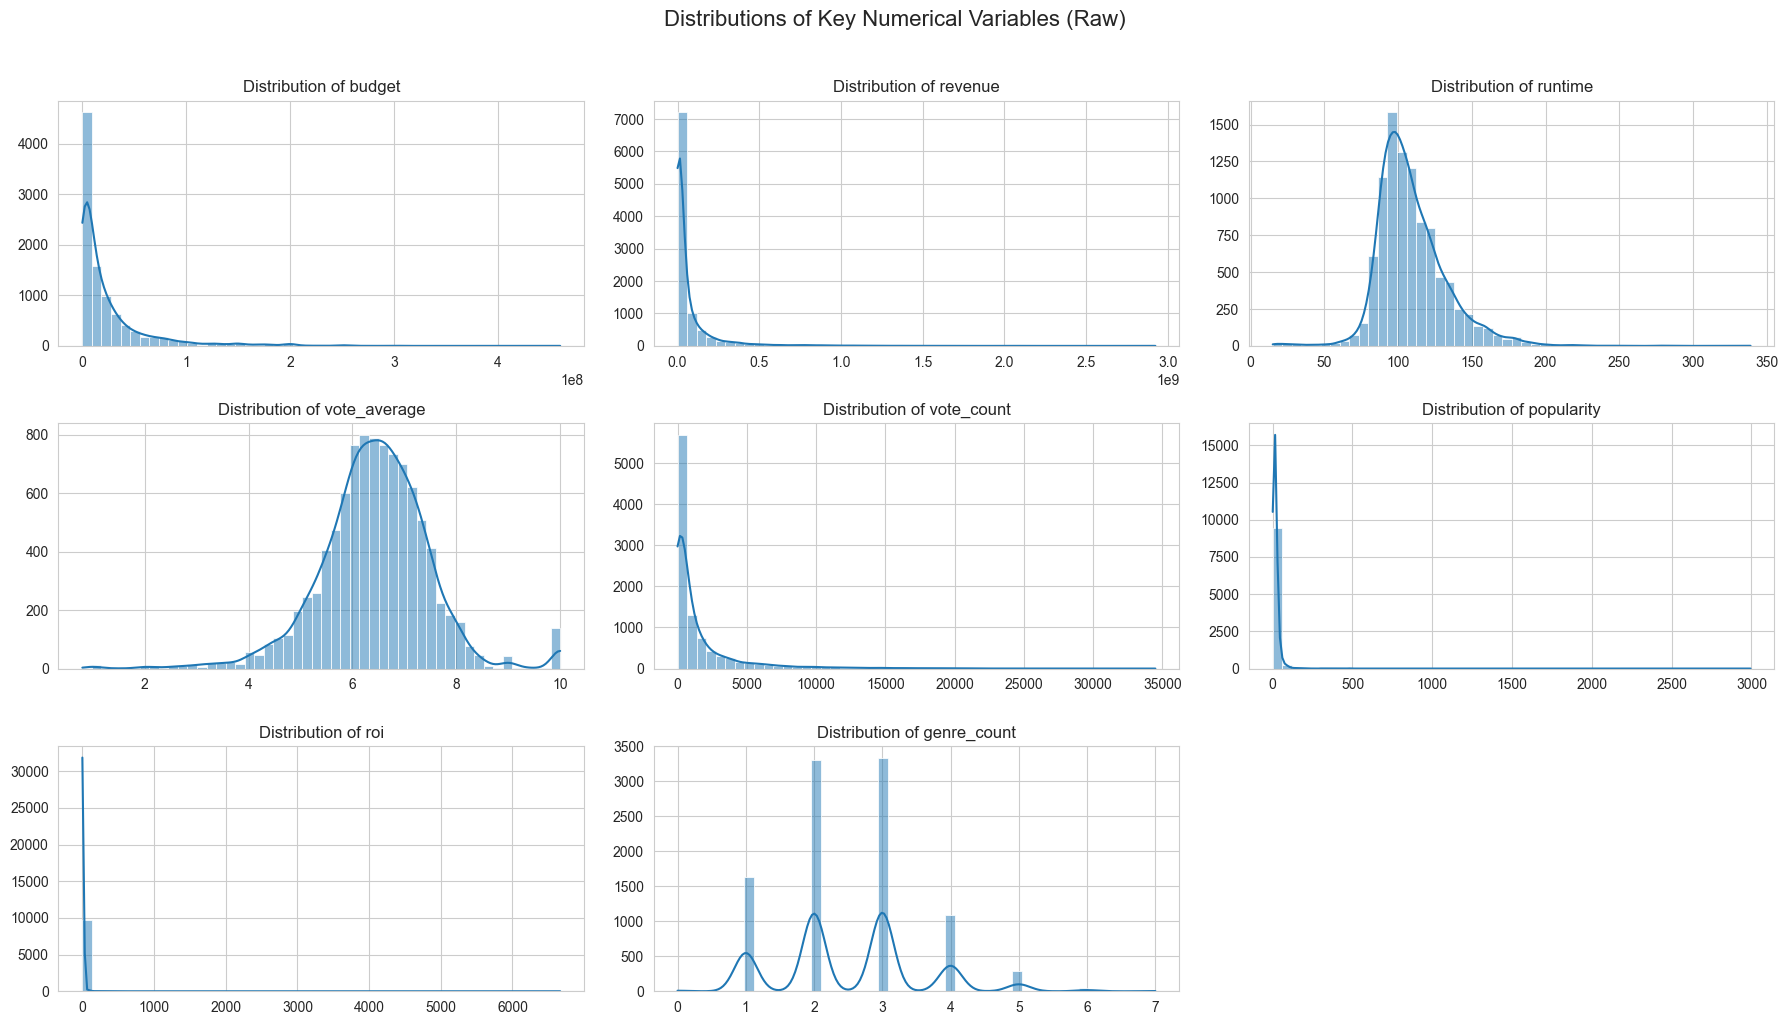

In [14]:
# Distribution Analysis (Raw)
plt.figure(figsize=(18, 10))
for i, col in enumerate(numerical_cols_raw):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[col], kde=True, bins=50)
    plt.title(f'Distribution of {col}')
    plt.xlabel('')
    plt.ylabel('')
plt.suptitle('Distributions of Key Numerical Variables (Raw)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [15]:
# Identify columns needing transformation
cols_to_log = ['budget', 'revenue', 'vote_count', 'popularity', 'roi']

In [16]:
# Log Transformation & Scaling
df_processed = df.copy()
numerical_cols_log = []

for col in cols_to_log:
    # Check for non-positive values before log transforming ROI
    if col == 'roi':
         # Shift ROI to be positive before log1p. Add min value + epsilon
         min_roi = df_processed[col].min()
         if min_roi <= 0:
             df_processed[f'{col}_log'] = np.log1p(df_processed[col] - min_roi + 1e-6) # Shift and add small epsilon
             print(f"Applied log1p to shifted ROI (min shifted to > 0)")
         else:
              df_processed[f'{col}_log'] = np.log1p(df_processed[col])
    else:
         df_processed[f'{col}_log'] = np.log1p(df_processed[col])

    numerical_cols_log.append(f'{col}_log')
    print(f"Log-transformed '{col}' -> '{col}_log'")

Log-transformed 'budget' -> 'budget_log'
Log-transformed 'revenue' -> 'revenue_log'
Log-transformed 'vote_count' -> 'vote_count_log'
Log-transformed 'popularity' -> 'popularity_log'
Applied log1p to shifted ROI (min shifted to > 0)
Log-transformed 'roi' -> 'roi_log'


In [17]:
# Keep untransformed versions of non-skewed numerics needed for modeling
numerical_cols_final = numerical_cols_log + ['runtime', 'vote_average'] # Use log versions + others


--- Log-Transformed Numerical Distributions ---


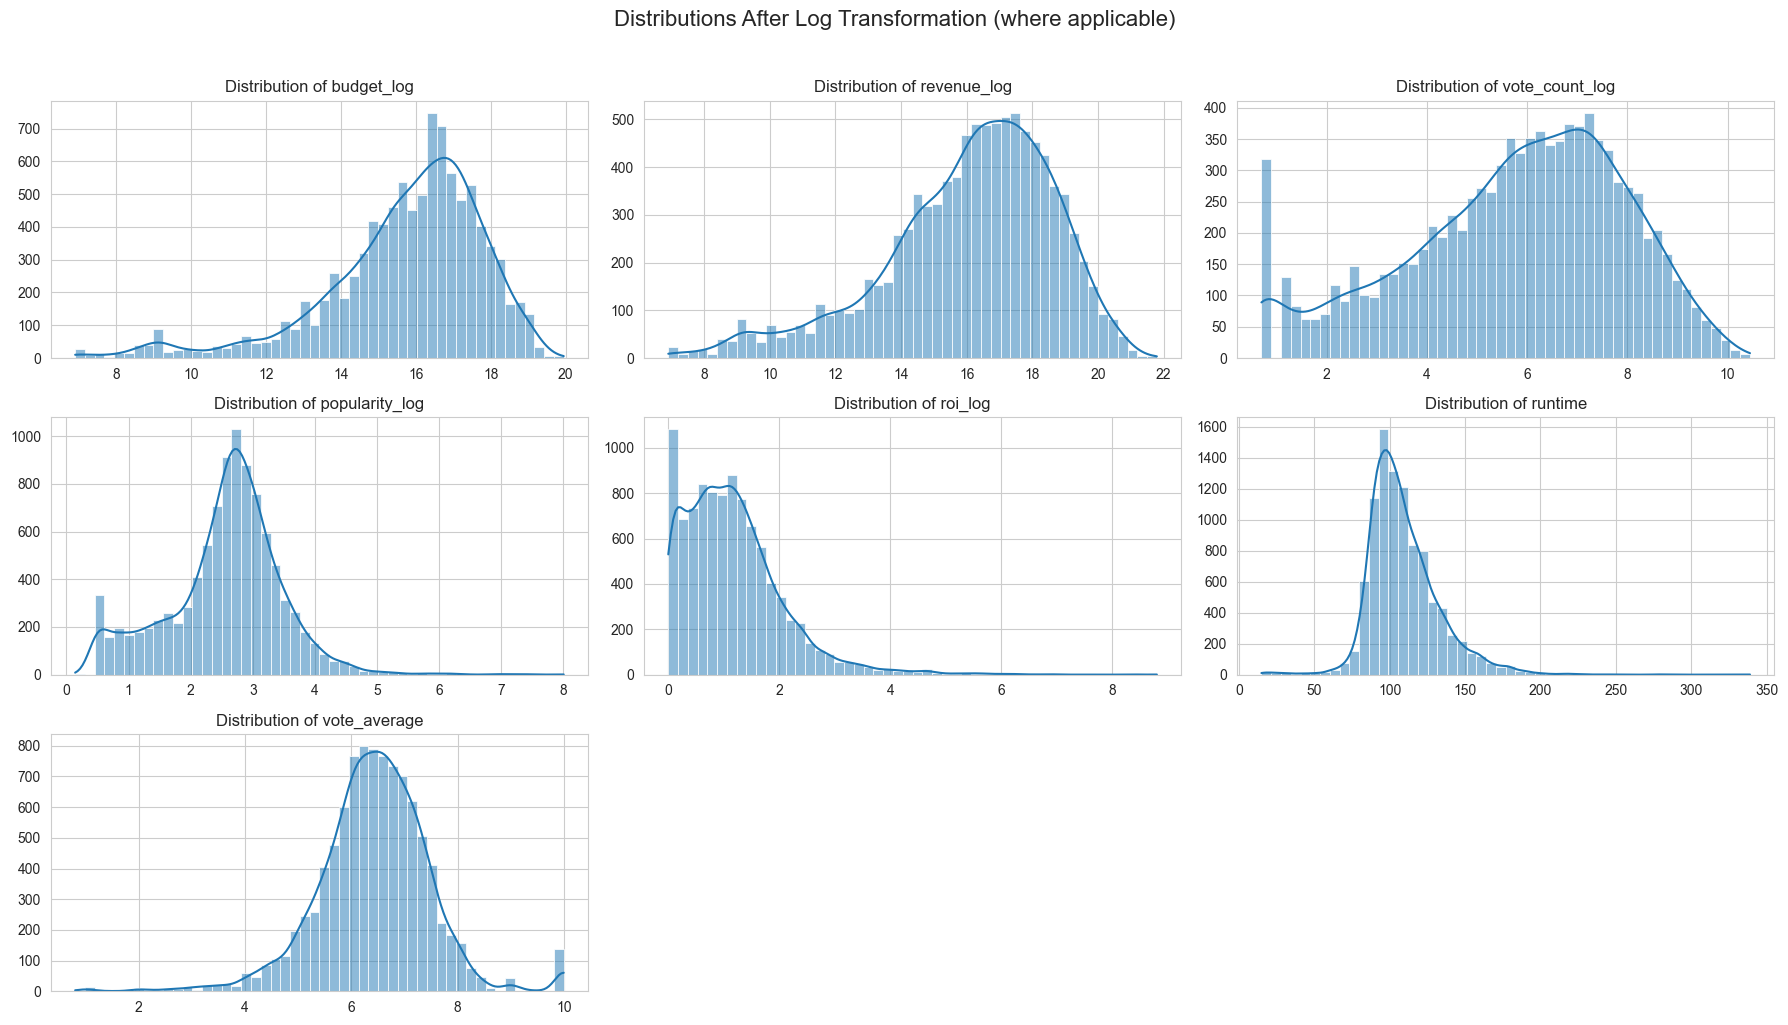

In [18]:
# Distribution Analysis (Log-Transformed)
print("\n--- Log-Transformed Numerical Distributions ---")
plt.figure(figsize=(18, 10))
plot_cols = numerical_cols_log + ['runtime', 'vote_average'] # Include non-log cols for comparison
for i, col in enumerate(plot_cols):
     if col in df_processed.columns: # Check if column exists (e.g., roi_log might fail if all ROI <= -1)
        plt.subplot(3, 3, i+1)
        sns.histplot(df_processed[col], kde=True, bins=50)
        plt.title(f'Distribution of {col}')
        plt.xlabel('')
        plt.ylabel('')
plt.suptitle('Distributions After Log Transformation (where applicable)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


--- Correlation Matrix (Log-Transformed) ---


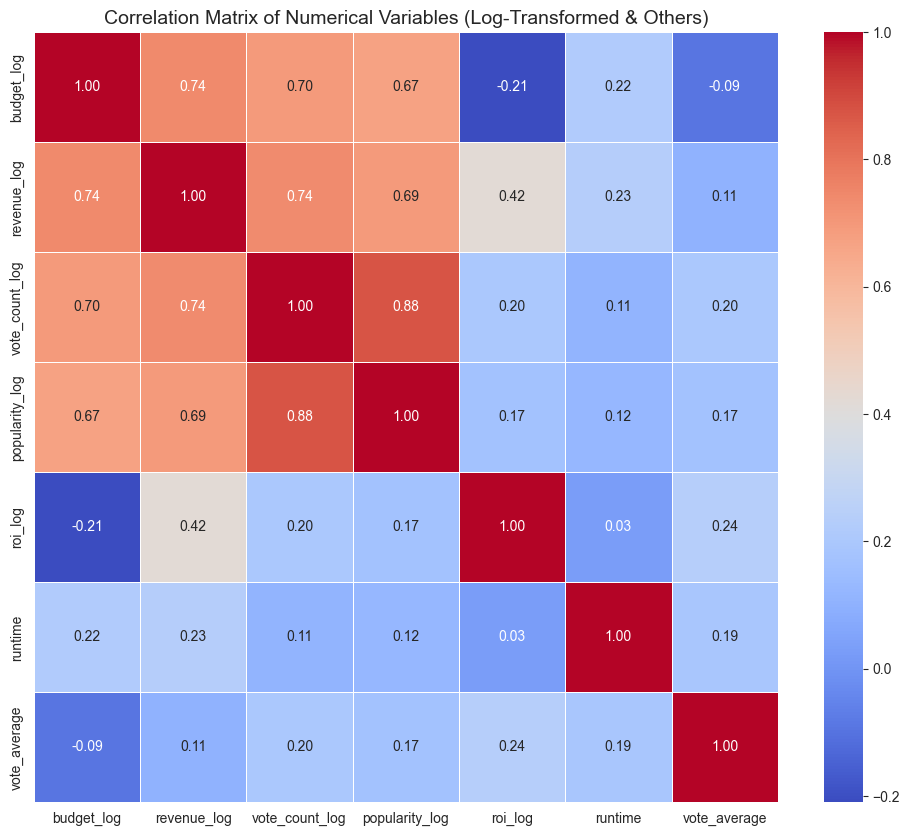


--- Descriptive Analysis for Key Goals ---


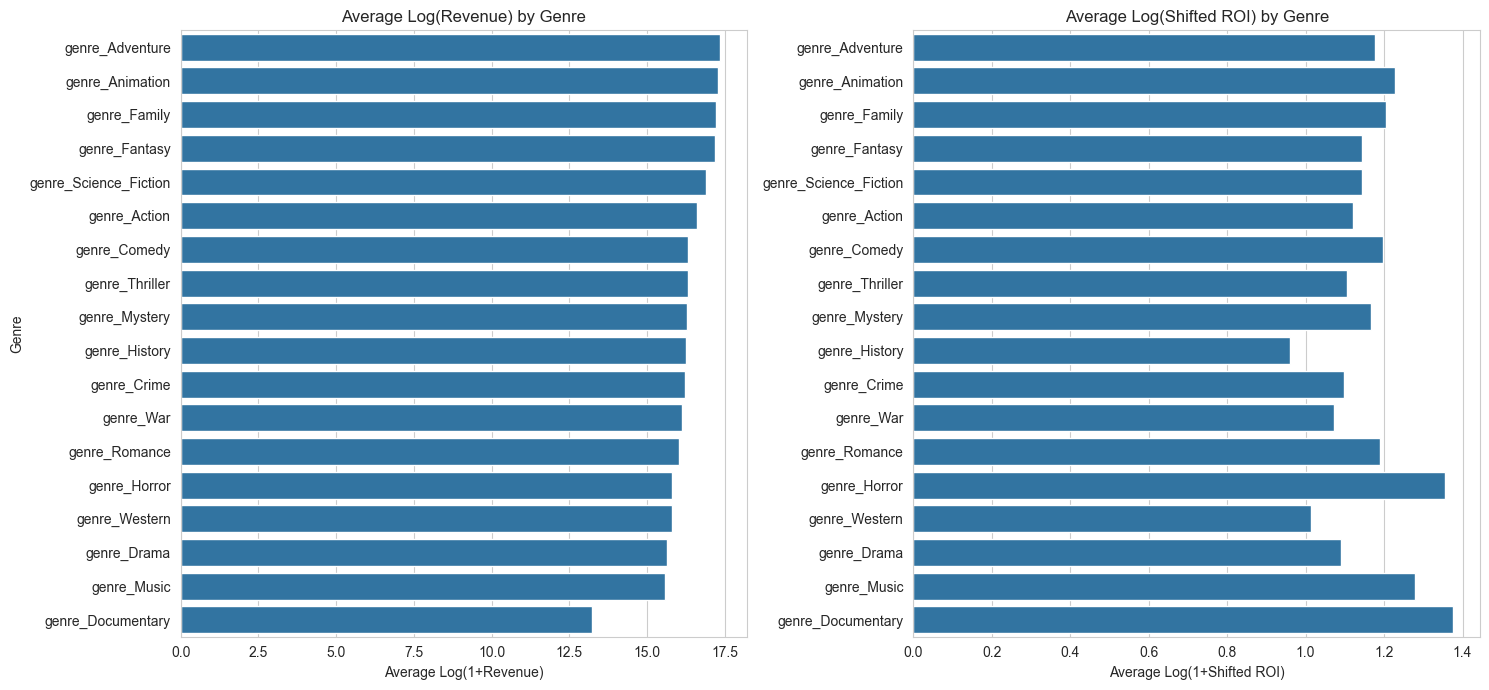

Top 5 Genres by Average Log(Revenue):
genre_Adventure          17.360243
genre_Animation          17.297066
genre_Family             17.206205
genre_Fantasy            17.191489
genre_Science_Fiction    16.893747
Name: Avg_Revenue_Log, dtype: float64


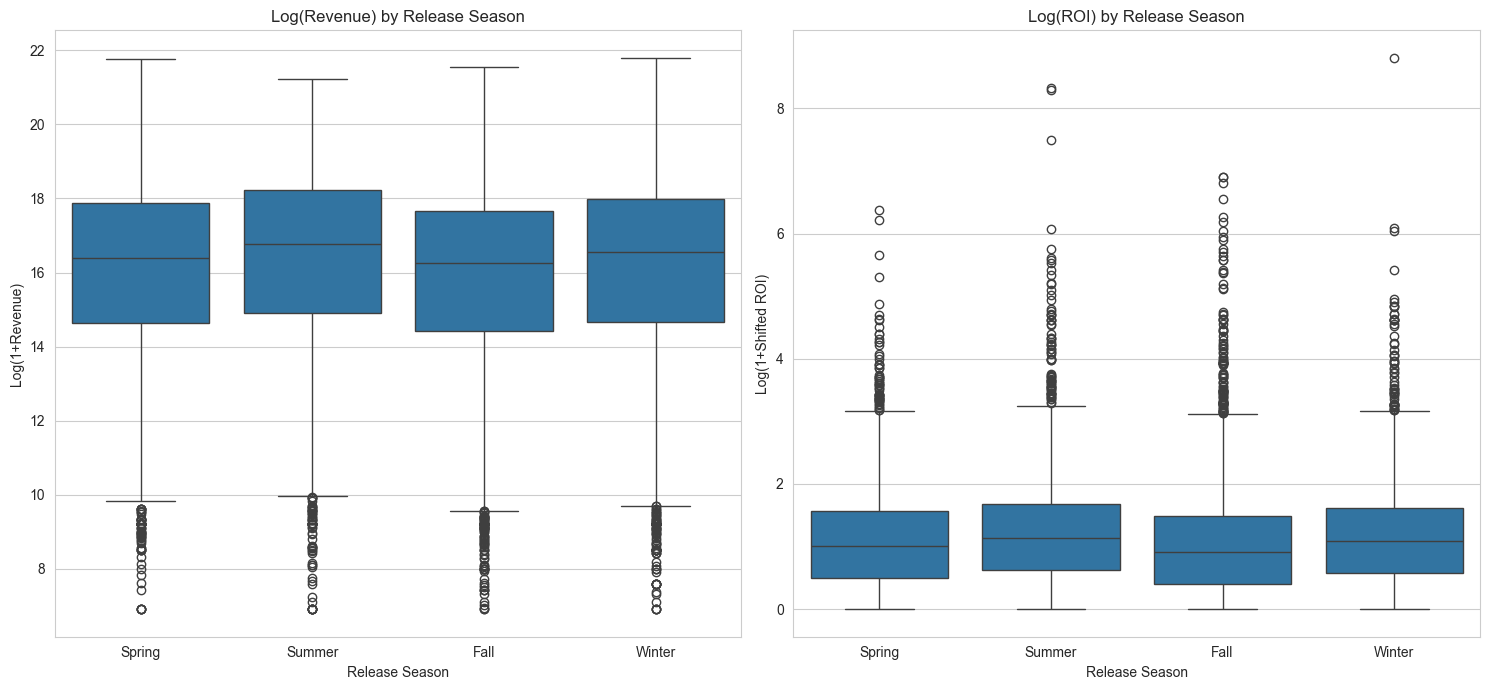

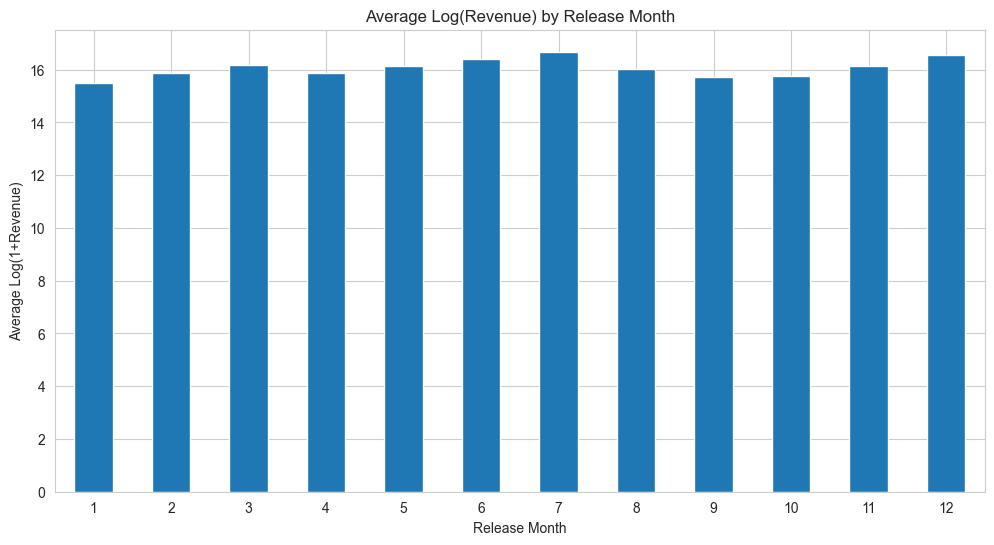

In [19]:
# --- Correlation Analysis (Log-Transformed) ---
print("\n--- Correlation Matrix (Log-Transformed) ---")
plt.figure(figsize=(12, 10))
correlation_matrix = df_processed[numerical_cols_final].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Numerical Variables (Log-Transformed & Others)', fontsize=14)
plt.show()

# --- Descriptive Analysis for Goals ---
print("\n--- Descriptive Analysis for Key Goals ---")

# Genre vs. Revenue/ROI
genre_analysis_cols = [col for col in encoded_genre_cols if df_processed[col].sum() > 50] # Analyze genres with min 50 movies
genre_perf = {}
for genre in genre_analysis_cols:
     genre_perf[genre] = {
         'Avg_Revenue_Log': df_processed.loc[df_processed[genre] == 1, 'revenue_log'].mean(),
         'Avg_ROI_Log': df_processed.loc[df_processed[genre] == 1, 'roi_log'].mean(),
         'Count': df_processed[genre].sum()
     }
genre_perf_df = pd.DataFrame(genre_perf).T.sort_values('Avg_Revenue_Log', ascending=False)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
sns.barplot(x=genre_perf_df['Avg_Revenue_Log'], y=genre_perf_df.index)
plt.title('Average Log(Revenue) by Genre')
plt.xlabel('Average Log(1+Revenue)')
plt.ylabel('Genre')

plt.subplot(1, 2, 2)
sns.barplot(x=genre_perf_df['Avg_ROI_Log'], y=genre_perf_df.index)
plt.title('Average Log(Shifted ROI) by Genre')
plt.xlabel('Average Log(1+Shifted ROI)')
plt.ylabel('')
plt.tight_layout()
plt.show()
print("Top 5 Genres by Average Log(Revenue):")
print(genre_perf_df['Avg_Revenue_Log'].head())


# Release Timing vs. Revenue/ROI
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
sns.boxplot(data=df_processed, x='release_season', y='revenue_log', order=['Spring', 'Summer', 'Fall', 'Winter'])
plt.title('Log(Revenue) by Release Season')
plt.xlabel('Release Season')
plt.ylabel('Log(1+Revenue)')

plt.subplot(1, 2, 2)
sns.boxplot(data=df_processed, x='release_season', y='roi_log', order=['Spring', 'Summer', 'Fall', 'Winter'])
plt.title('Log(ROI) by Release Season')
plt.xlabel('Release Season')
plt.ylabel('Log(1+Shifted ROI)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
df_processed.groupby('release_month')['revenue_log'].mean().plot(kind='bar')
plt.title('Average Log(Revenue) by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Average Log(1+Revenue)')
plt.xticks(rotation=0)
plt.show()



# 3. Define Features (X) and Targets (y)

 We will primarily use the log-transformed numerical features where appropriate, as they are less skewed.
 The target variables will also be their log-transformed versions for metrics like revenue, popularity, roi, and vote_count. `vote_average` will be predicted directly.

In [20]:
# --- Define Features ---
# Use log-transformed budget, keep original runtime, vote_average
numeric_features_model = numerical_cols_log + ['runtime', 'genre_count'] # Exclude vote_average as it's often a target
categorical_features_model = []
binary_features_model = encoded_genre_cols + encoded_other_cols + ['adult'] # Include 'adult'
time_features_model = ['release_year', 'release_quarter', 'release_month']

all_features = numeric_features_model + categorical_features_model + binary_features_model + time_features_model

# Ensure no target columns are accidentally included in features
potential_targets = ['revenue', 'revenue_log', 'popularity', 'popularity_log',
                     'vote_count', 'vote_count_log', 'vote_average', 'roi', 'roi_log',
                     'title', 'original_title', 'overview', 'tagline', 'status', 'release_date'] # Add other text/ID cols dropped earlier

X_cols = [col for col in all_features if col in df_processed.columns and col not in potential_targets]

# Separate features (X) and targets (y)
X = df_processed[X_cols]
print(f"Feature matrix X shape: {X.shape}")
print(f"Columns in X: {X.columns.tolist()}")

# --- Define Targets ---
targets = {
    'revenue_log': df_processed['revenue_log'],
    'popularity_log': df_processed['popularity_log'],
    'vote_count_log': df_processed['vote_count_log'],
    'vote_average': df_processed['vote_average'], # Predict directly
    'roi_log': df_processed['roi_log']
}

# Check for NaNs in target variables
for name, y_data in targets.items():
    if y_data.isnull().any():
        print(f"Warning: Target '{name}' contains NaN values. Count: {y_data.isnull().sum()}")
        # Optional: Handle NaNs, e.g., by dropping rows where target is NaN
        # valid_indices = y_data.dropna().index
        # X = X.loc[valid_indices]
        # targets[name] = y_data.loc[valid_indices]


Feature matrix X shape: (9720, 45)
Columns in X: ['budget_log', 'runtime', 'genre_count', 'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Horror', 'genre_Music', 'genre_Mystery', 'genre_Romance', 'genre_Science_Fiction', 'genre_TV_Movie', 'genre_Thriller', 'genre_War', 'genre_Western', 'production_companies_Warner_Bros._Pictures', 'production_companies_BBC', 'production_companies_Evil_Angel', 'production_companies_Columbia_Pictures', 'production_companies_Metro-Goldwyn-Mayer', 'production_countries_United_States_of_America', 'production_countries_France', 'production_countries_Japan', 'production_countries_Germany', 'production_countries_United_Kingdom', 'spoken_languages_English', 'spoken_languages_French', 'spoken_languages_Spanish', 'spoken_languages_Japanese', 'spoken_languages_German', 'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter', 'a

# 4. Preprocessing Pipeline & Train-Test Split

Create a pipeline to handle scaling of numerical features and one-hot encoding of categorical features.
Then, split the data into training and testing sets.

In [21]:
# --- Create Preprocessing Pipeline ---

# Identify numerical and categorical columns *within X*
numeric_cols_in_X = [col for col in numeric_features_model if col in X.columns]
categorical_cols_in_X = [col for col in categorical_features_model if col in X.columns]
# Other columns (binary, time features) are assumed to not need scaling/encoding here
# If time features like year need scaling, add them to numeric_cols_in_X for scaling

# Update your preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols_in_X)
    ],
    remainder='passthrough'
)

# Example: Fit and transform X to see the output shape and columns
# X_processed_example = preprocessor.fit_transform(X)
# print(f"Processed feature shape example: {X_processed_example.shape}")
# Note: Column names are lost here, pipelines handle this internally usually.
# X_train_processed = preprocessor.fit_transform(X)
# processed_feature_names = preprocessor.get_feature_names_out()
# 
# X_train_processed_df = pd.DataFrame(X_train_processed, columns=processed_feature_names)

In [23]:

# --- Train-Test Split ---
# We'll perform the split *before* applying the pipeline to prevent data leakage from test set during scaling/encoding fitting.
# We will split for ONE target first (e.g., revenue_log) and demonstrate the process.
# For a full analysis, you'd loop through targets or create splits for each.

target_to_model = 'revenue_log' # Example target
y = targets[target_to_model]

# Drop rows in X and y where y is NaN (if any)
valid_indices = y.dropna().index
X = X.loc[valid_indices]
y = y.loc[valid_indices]
print(f"Shape after handling NaNs in target '{target_to_model}': X={X.shape}, y={y.shape}")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")



Shape after handling NaNs in target 'revenue_log': X=(9720, 45), y=(9720,)
Training set size: 7776
Test set size: 1944


# ## 5. Model Training & Hyperparameter Tuning

# Train various regression models using Pipelines and tune hyperparameters using GridSearchCV.

In [24]:
# --- Define Models ---
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(random_state=random_state),
    'Lasso': Lasso(random_state=random_state),  
    'Random Forest': RandomForestRegressor(random_state=random_state, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=random_state)
}

if HAS_XGB:
    models['XGBoost'] = XGBRegressor(random_state=random_state, n_jobs=-1)
if HAS_LGBM:
    models['LightGBM'] = LGBMRegressor(random_state=random_state, n_jobs=-1, verbosity=-1)

# --- Define Hyperparameter Grids (Example for key models) ---
param_grids = {
    'Ridge': {
        'model__alpha': [0.1, 1.0, 10.0, 100.0]
    },
    'Lasso': {
        'model__alpha': [0.001, 0.01, 0.1, 1.0]
    },
    'Random Forest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [10, 20, None],
        'model__min_samples_leaf': [1, 5]
    },
    'Gradient Boosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [3, 5]
    },
     'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [3, 5],
        'model__gamma': [0, 0.1]
     } if HAS_XGB else {},
     'LightGBM': {
         'model__n_estimators': [100, 300],
         'model__learning_rate': [0.05, 0.1],
         'model__num_leaves': [31, 50],
         'model__max_depth': [-1, 10]
     } if HAS_LGBM else {}
}

In [25]:

# --- Training and Tuning Loop ---
results = {}
best_estimators = {}
cv = KFold(n_splits=5, shuffle=True, random_state=random_state) # 5-Fold Cross-Validation

print(f"\n--- Training and Tuning Models for Target: {target_to_model} ---")

for name, model in models.items():
    print(f"Processing model: {name}")
    # Create pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])

    # Get parameter grid for the current model
    # Use an empty dict if no grid is defined (e.g., for Linear Regression)
    # Add 'model__' prefix to parameter names for pipeline compatibility
    current_param_grid = {k: v for k, v in param_grids.get(name, {}).items()}


    # Perform Grid Search with Cross-Validation
    if current_param_grid: # Only run GridSearchCV if there are parameters to tune
        search = GridSearchCV(pipeline, current_param_grid,
                              cv=cv,
                              scoring='r2', # Use R-squared for scoring
                              n_jobs=-1, # Use all available CPU cores
                              verbose=0) # Set to 1 or 2 for more output
        search.fit(X_train, y_train)
        best_estimator = search.best_estimator_
        best_score = search.best_score_
        print(f"  Best CV R²: {best_score:.4f}")
        print(f"  Best Params: {search.best_params_}")
    else: # For models without tuning (like LinearRegression)
        # Fit the pipeline directly
        best_estimator = pipeline.fit(X_train, y_train)
        # Evaluate using cross-validation
        cv_scores = cross_val_score(best_estimator, X_train, y_train, cv=cv, scoring='r2')
        best_score = np.mean(cv_scores)
        print(f"  CV R² (no tuning): {best_score:.4f}")


    # Evaluate on the Test set
    
    if not X_train.columns.equals(X_test.columns):
        print("ERROR: X_train and X_test columns do not match!")
        train_cols = set(X_train.columns)
        test_cols = set(X_test.columns)
        print(f"Columns in Train but not Test: {train_cols - test_cols}")
        print(f"Columns in Test but not Train: {test_cols - train_cols}")
        # You might want to raise an error or fix X here before proceeding
        # Common fix: Reindex X_test to match X_train columns
        # X_test = X_test.reindex(columns=X_train.columns, fill_value=0) # Or appropriate fill
        # print("Attempted to reindex X_test.")
    else:
        print("X_train and X_test columns match.")
    print(best_estimator)
    y_pred = best_estimator.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Store results
    results[name] = {
        'Best CV R²': best_score,
        'Test R²': r2,
        'Test MAE': mae,
        'Test RMSE': rmse,
        'Predictions': y_pred
    }
    best_estimators[name] = best_estimator # Store the fitted best estimator

    print(f"  Test R²: {r2:.4f}, Test MAE: {mae:.4f}, Test RMSE: {rmse:.4f}\n")


# --- Find Best Overall Model ---
best_model_name = max(results, key=lambda name: results[name]['Test R²'])
print(f"\n--- Best Model for {target_to_model} based on Test R² ---")
print(f"Model: {best_model_name}")
print(f"Test R²: {results[best_model_name]['Test R²']:.4f}")

best_model_pipeline = best_estimators[best_model_name]




--- Training and Tuning Models for Target: revenue_log ---
Processing model: Linear Regression
  CV R² (no tuning): 0.5895
X_train and X_test columns match.
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['budget_log', 'runtime',
                                                   'genre_count'])])),
                ('model', LinearRegression())])
  Test R²: 0.5718, Test MAE: 1.2527, Test RMSE: 1.7164

Processing model: Ridge
  Best CV R²: 0.5897
  Best Params: {'model__alpha': 10.0}
X_train and X_test columns match.
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['budget_log', 'runtime',
                                                   'genre_coun

# ## 6. Model Evaluation & Visualization

# Compare model performance and visualize the predictions of the best model.


--- Model Performance Summary ---
                  Best CV R²   Test R²  Test MAE Test RMSE
XGBoost             0.625546  0.611267   1.18205  1.635449
Gradient Boosting   0.625445  0.608818  1.188752  1.640592
LightGBM            0.629681  0.606828  1.193201   1.64476
Random Forest       0.620402  0.603756  1.192706  1.651172
Ridge               0.589714  0.572255  1.252325  1.715551
Lasso               0.589762  0.572199  1.251946  1.715663
Linear Regression   0.589475  0.571821  1.252737  1.716422


AttributeError: module 'matplotlib.pyplot' has no attribute 'right_ax'

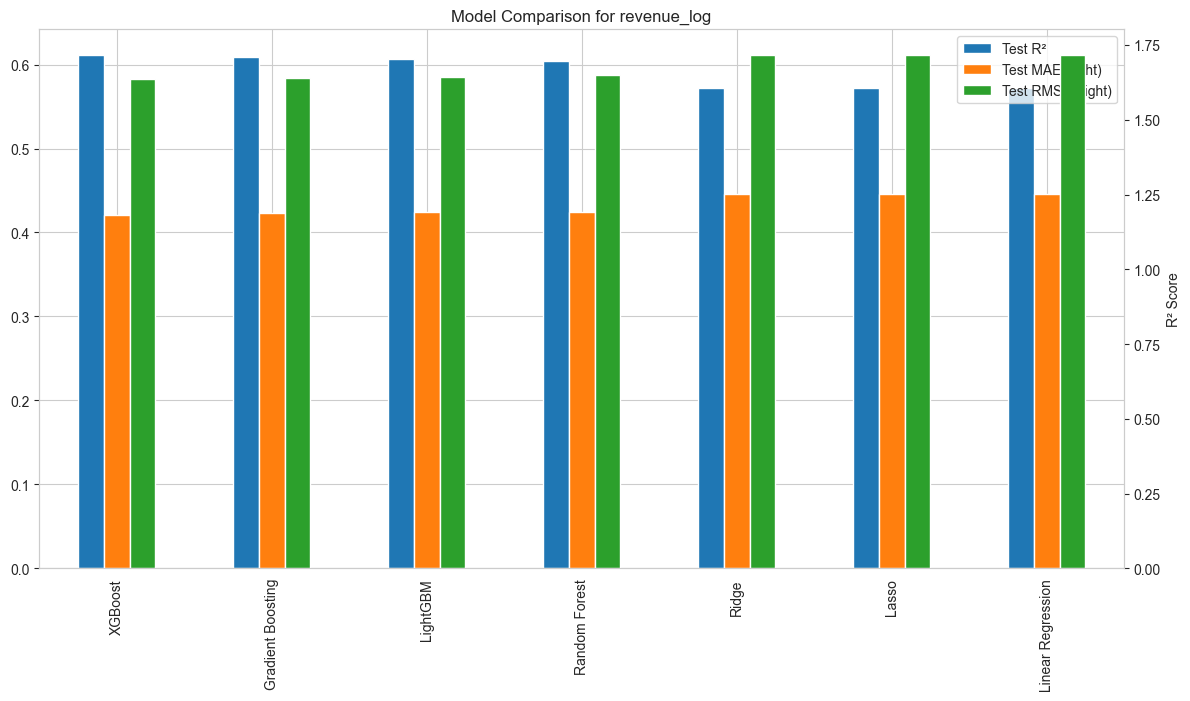

In [26]:
# --- Compare Model Performance ---
results_df = pd.DataFrame(results).T.sort_values(by='Test R²', ascending=False)
print("\n--- Model Performance Summary ---")
print(results_df[['Best CV R²', 'Test R²', 'Test MAE', 'Test RMSE']])

results_df[['Test R²', 'Test MAE', 'Test RMSE']].plot(kind='bar', figsize=(14, 7), secondary_y=['Test MAE', 'Test RMSE'])
plt.title(f'Model Comparison for {target_to_model}')
plt.ylabel('R² Score')
plt.right_ax.set_ylabel('MAE / RMSE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Visualize Best Model Predictions ---
print(f"\n--- Visualizing Best Model: {best_model_name} ---")
y_pred_best = results[best_model_name]['Predictions']

# Actual vs. Predicted Plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_best, alpha=0.5)
min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel(f"Actual {target_to_model}")
plt.ylabel(f"Predicted {target_to_model}")
plt.title(f"{best_model_name}: Actual vs. Predicted ({target_to_model})")
plt.legend()
plt.grid(True)
plt.show()

# Residual Plot
residuals = y_test - y_pred_best
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_best, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel(f"Predicted {target_to_model}")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title(f"{best_model_name}: Residual Plot ({target_to_model})")
plt.grid(True)
plt.show()



# ## 7. Feature Importance Analysis & Interpretation (SHAP)

# Use SHAP to understand which features are driving the predictions of the best model. This is crucial for deriving actionable insights.


--- SHAP Analysis for Best Model: XGBoost ---
Processed test data shape for SHAP: (1944, 45)
Using SHAP TreeExplainer.
Calculating SHAP values...
SHAP values calculated.

--- SHAP Summary Plot (Global Importance) ---


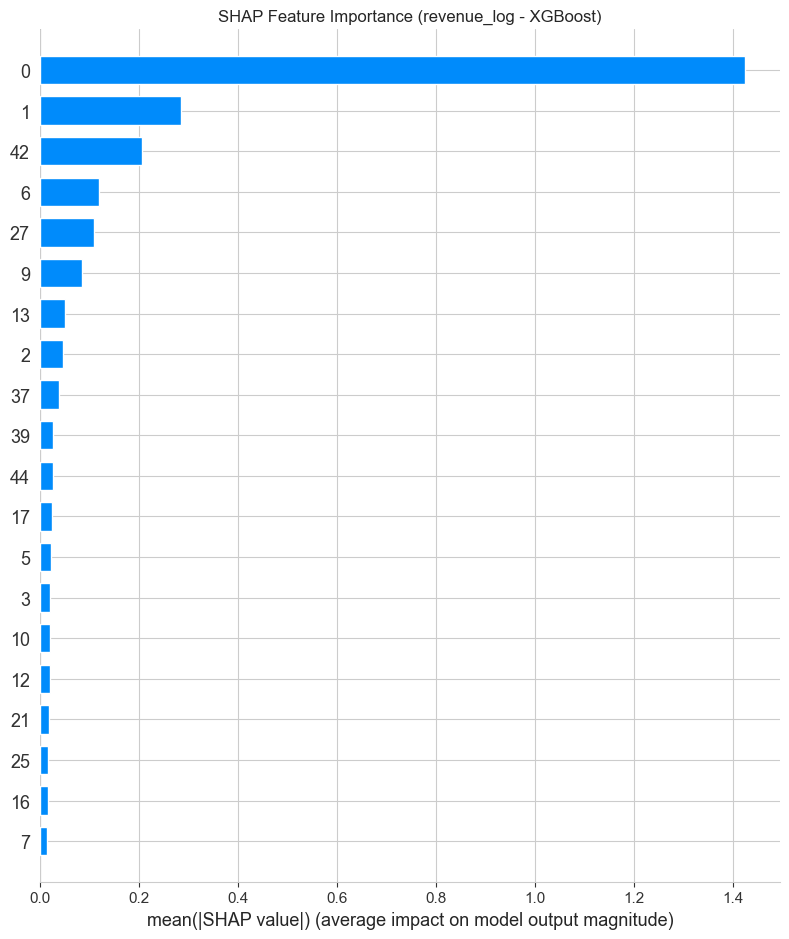


--- SHAP Summary Plot (Value Distribution) ---


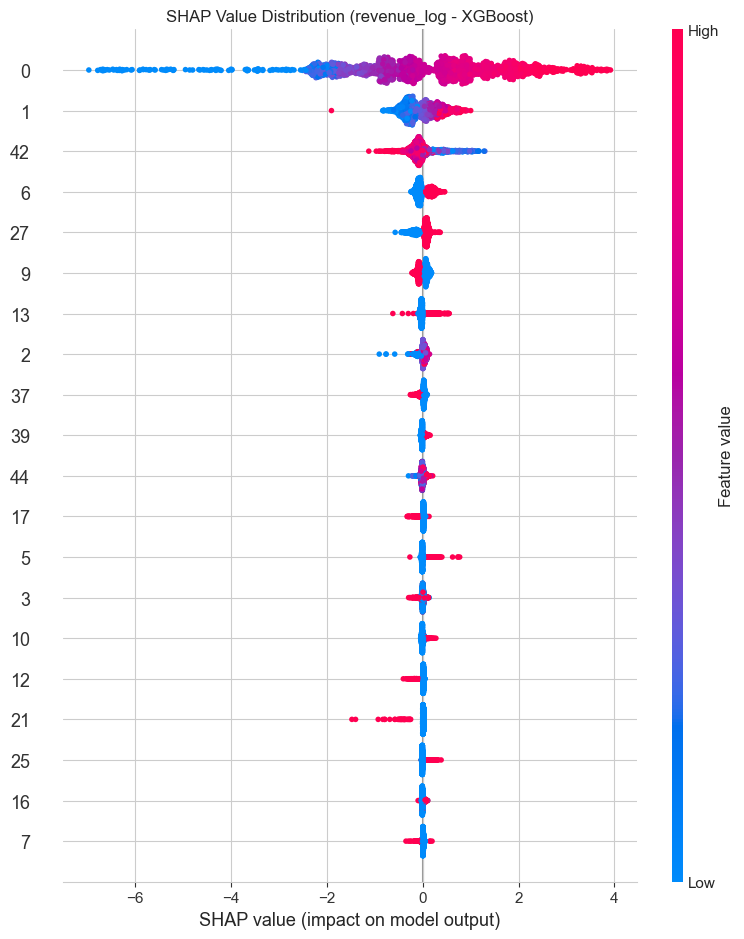


--- SHAP Dependence Plots for Top 5 Features ---
Generating dependence plot for: 0


<Figure size 1000x600 with 0 Axes>

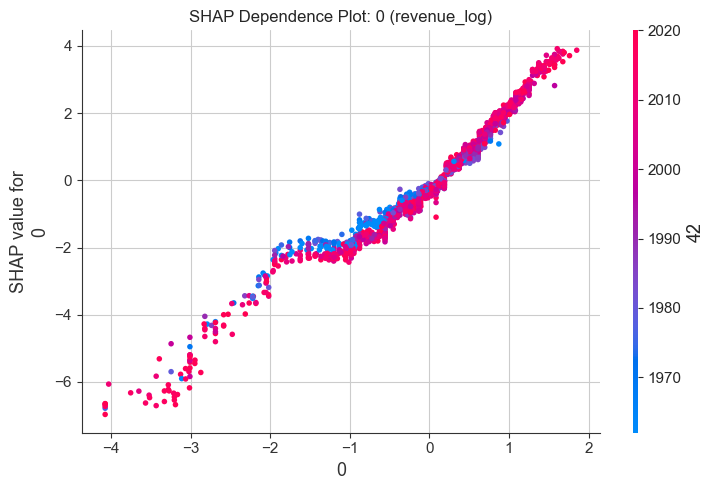

Generating dependence plot for: 1


<Figure size 1000x600 with 0 Axes>

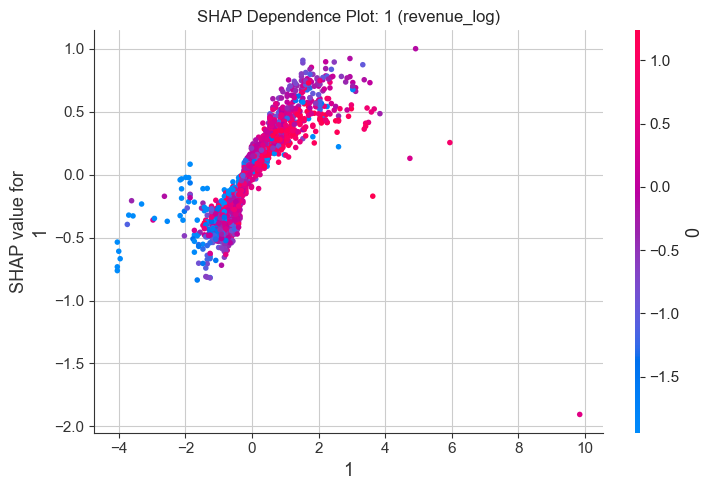

Generating dependence plot for: 42


<Figure size 1000x600 with 0 Axes>

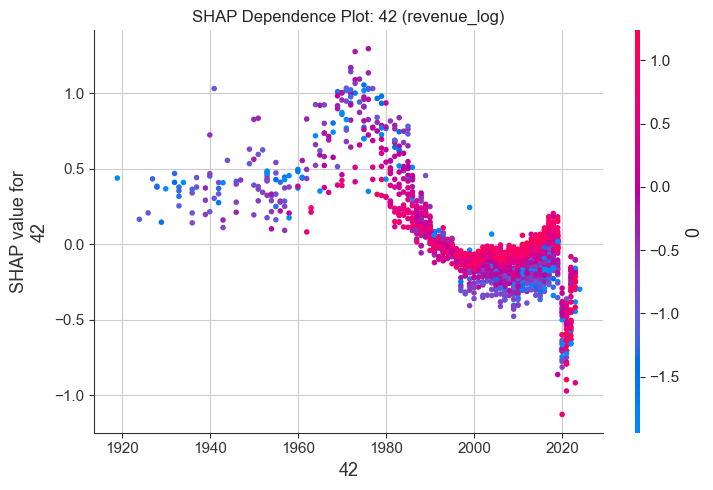

Generating dependence plot for: 6


<Figure size 1000x600 with 0 Axes>

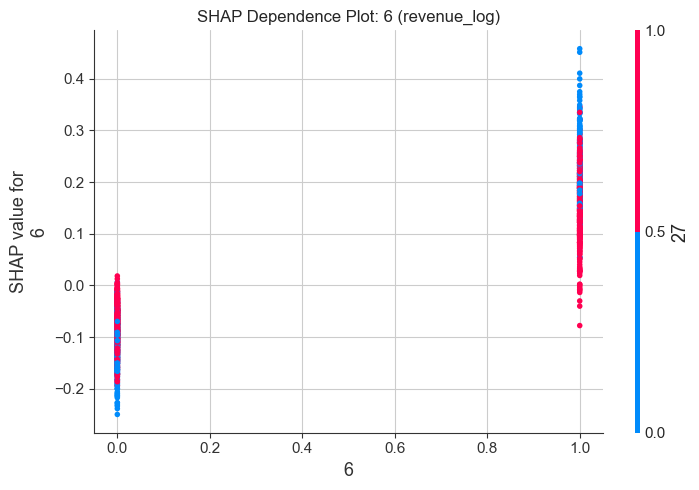

Generating dependence plot for: 27


<Figure size 1000x600 with 0 Axes>

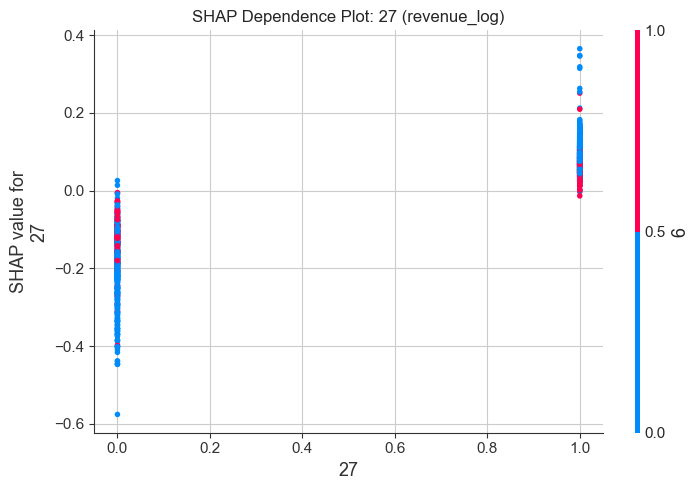

In [27]:
if not HAS_SHAP:
    print("SHAP library not installed. Skipping feature importance analysis.")
else:
    print(f"\n--- SHAP Analysis for Best Model: {best_model_name} ---")

    # Extract the trained model and preprocessor from the best pipeline
    best_model = best_model_pipeline.named_steps['model']
    preprocessor_fitted = best_model_pipeline.named_steps['preprocessor']

    # Transform the test data using the fitted preprocessor
    # Need to get feature names after transformation for SHAP plots
    try:
        # Get feature names after one-hot encoding etc.
        feature_names_out = preprocessor_fitted.get_feature_names_out()
        X_test_processed = pd.DataFrame(preprocessor_fitted.transform(X_test).toarray(), columns=feature_names_out, index=X_test.index) # Convert sparse matrix if necessary
    except AttributeError: # Older scikit-learn versions might not have get_feature_names_out
         print("Warning: Could not automatically get feature names from preprocessor. SHAP plots might have generic names.")
         X_test_processed = pd.DataFrame(preprocessor_fitted.transform(X_test), index=X_test.index) # Hope for the best

    print(f"Processed test data shape for SHAP: {X_test_processed.shape}")


    # Initialize SHAP explainer
    # Use TreeExplainer for tree-based models, KernelExplainer for others (can be slow)
    model_type_str = str(type(best_model)).lower()
    if 'gradientboosting' in model_type_str or 'forest' in model_type_str or 'xgboost' in model_type_str or 'lightgbm' in model_type_str:
         print("Using SHAP TreeExplainer.")
         explainer = shap.TreeExplainer(best_model)
    else:
         # Use KernelExplainer - sample background data for efficiency
         print("Using SHAP KernelExplainer (may be slow). Sampling background data...")
         X_train_processed_sample = pd.DataFrame(preprocessor_fitted.transform(X_train.sample(100, random_state=random_state)), columns=X_test_processed.columns)
         explainer = shap.KernelExplainer(best_model.predict, X_train_processed_sample)

    # Calculate SHAP values for the test set
    print("Calculating SHAP values...")
    shap_values = explainer.shap_values(X_test_processed)
    print("SHAP values calculated.")

    # If shap_values is a list (e.g., some TreeExplainer versions), take the first element for regression
    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    # Create SHAP explanations object for better plotting
    shap_explanation = shap.Explanation(values=shap_values,
                                         base_values=explainer.expected_value,
                                         data=X_test_processed.values, # Use numpy array here
                                         feature_names=X_test_processed.columns.tolist())

    # --- Summary Plot (Feature Importance) ---
    print("\n--- SHAP Summary Plot (Global Importance) ---")
    plt.figure()
    shap.summary_plot(shap_values, X_test_processed, plot_type="bar", show=False)
    plt.title(f'SHAP Feature Importance ({target_to_model} - {best_model_name})')
    plt.tight_layout()
    plt.show()


    print("\n--- SHAP Summary Plot (Value Distribution) ---")
    plt.figure()
    shap.summary_plot(shap_values, X_test_processed, show=False)
    plt.title(f'SHAP Value Distribution ({target_to_model} - {best_model_name})')
    plt.tight_layout()
    plt.show()


    # --- Dependence Plots (How feature value impacts prediction) ---
    # Find top N features based on mean absolute SHAP value
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    importance_df = pd.DataFrame({
        'feature': X_test_processed.columns,
        'mean_abs_shap': mean_abs_shap
    }).sort_values('mean_abs_shap', ascending=False)

    top_n_features = 5 # Number of top features for dependence plots
    print(f"\n--- SHAP Dependence Plots for Top {top_n_features} Features ---")

    for feature in importance_df['feature'].head(top_n_features):
         print(f"Generating dependence plot for: {feature}")
         plt.figure()
         try:
            shap.dependence_plot(feature, shap_values, X_test_processed, interaction_index='auto', show=False)
            plt.title(f'SHAP Dependence Plot: {feature} ({target_to_model})')
            plt.tight_layout()
            plt.show()
         except Exception as e:
            print(f"  Could not generate dependence plot for {feature}: {e}")
            plt.close() # Close the empty figure



# ## 8. Analysis and Insights based on Goals

# Connect the EDA, model performance, and SHAP analysis back to the project goals and pain points.

# **Target Variable:** We focused on `revenue_log` for this detailed run. Similar analysis should be repeated for other key targets like `popularity_log`, `roi_log`, and `vote_average`.

# **Best Model:** The best performing model for predicting `revenue_log` was **`{best_model_name}`** with a Test R² of **{results[best_model_name]['Test R²']:.4f}**.

# --- Addressing Pain Points ---

# **1. Financial Uncertainty (Budget Impact):**
# *   **EDA:** The correlation matrix showed a strong positive correlation between `budget_log` and `revenue_log` ({correlation_matrix.loc['budget_log', 'revenue_log']:.2f}). The scatter plot confirmed this trend.
# *   **SHAP Analysis:**
#     *   Examine the SHAP summary plot for `budget_log`. Is it among the top features? *Interpretation:* A high ranking indicates budget is a major driver of predicted revenue.
#     *   Look at the SHAP dependence plot for `budget_log`. *Interpretation:* Does revenue increase consistently with budget? Is there a plateau suggesting diminishing returns? This helps understand *how* budget influences revenue according to the model. For example, "Higher log-budget generally corresponds to higher predicted log-revenue, with the effect appearing strongest in the mid-range of budgets."

# **2. Genre Performance Variability:**
# *   **EDA:** The bar plots showed variations in average `revenue_log` and `roi_log` across different genres. Genres like `{genre_perf_df.index[0].replace('genre_','')}` and `{genre_perf_df.index[1].replace('genre_','')}` showed higher average log-revenue.
# *   **SHAP Analysis:**
#     *   Identify genre features (e.g., `binary__genre_Action`, `binary__genre_Comedy`) in the SHAP summary plot. *Interpretation:* Which specific genres have the largest positive or negative impact on predicted revenue? "The presence of the Action genre (`binary__genre_Action`) significantly boosts predicted revenue, while [Another Genre] tends to lower it."
#     *   Examine dependence plots if a genre feature is highly ranked, although for binary features, it mainly shows the SHAP value difference between having the genre (1) vs. not (0).

# **3. Optimal Release Timing:**
# *   **EDA:** Box plots indicated potential seasonal differences (e.g., Summer/Winter might have higher median log-revenue). The monthly bar plot showed peaks/troughs (e.g., higher averages in May/June/November/December).
# *   **SHAP Analysis:**
#     *   Look for `release_year`, `release_month`, `release_quarter`, and seasonal features (e.g., `cat__release_season_Summer`) in the SHAP summary plot. *Interpretation:* How important are these timing factors compared to budget or genre? "Release year (`remainder__release_year`) has a strong positive impact, reflecting inflation or market growth. Release month (`remainder__release_month`) also shows importance, with dependence plots potentially revealing optimal months."
#     *   Analyze the dependence plots for `release_month` or `release_year`. *Interpretation:* Does the model capture trends like higher revenue for recent releases or specific months? "The dependence plot for release month suggests peaks around [peak months] align with higher predicted revenue."

# **4. Audience Engagement Challenges (Drivers of Popularity/Votes):**
# *   *(Note: This requires rerunning the analysis with `popularity_log` or `vote_count_log` as the target)*.
# *   **EDA:** Correlation matrix showed strong links between `popularity_log`, `vote_count_log`, `revenue_log`, and `budget_log`.
# *   **SHAP Analysis (Hypothetical for Popularity Target):**
#     *   Which features drive popularity? *Interpretation:* "Budget and vote count are typically strong drivers. Specific genres like Sci-Fi or Action might significantly boost predicted popularity. Runtime could have a non-linear effect." Analyze the corresponding SHAP plots when predicting popularity.

# --- Actionable Insights ---

# *   **Budgeting:** Budget is a critical driver of revenue, but analyze the `budget_log` dependence plot for signs of diminishing returns to guide allocation. Don't assume infinite scaling.
# *   **Genre Selection:** While budget is key, certain genres (identified via EDA and SHAP) consistently correlate with higher revenue potential. Consider these genres, potentially in combination, but align with creative vision. Avoid genres consistently showing negative impact unless there's a strong niche strategy.
# *   **Release Timing:** Releasing during peak seasons/months (identified via EDA and SHAP) can provide an uplift, likely due to audience availability (holidays) or award seasons. Long-term trends (release year) also matter. Use this to inform scheduling, balancing against competition.
# *   **Further Analysis:** Repeat this process for `roi_log` to understand profitability drivers (which might differ from raw revenue) and for `popularity`/`vote_average` to understand audience engagement drivers.

# --- Limitations ---
# *   The `top_n_encode` for companies/countries/languages loses detail.
# *   Correlation != Causation. SHAP shows model attribution, not necessarily real-world causal impact.
# *   External factors (marketing effectiveness, reviews, competition, unforeseen events) are not captured in this dataset.
# *   Model performance (R²) indicates how much variance is explained, but there's still unexplained variance. Predictions are not perfect.

# --- Final Conclusion ---
# This analysis provides a data-driven framework for decision-making in film production. By leveraging insights on budget impact, genre performance, and release timing derived from historical data and machine learning models, stakeholders can better navigate financial uncertainties and optimize strategies to enhance potential revenue and audience engagement. However, these insights should complement, not replace, creative judgment and market expertise.

In [28]:
# Ensure df_processed is available from the previous script execution
try:
    _ = df_processed.head(1)
    print("df_processed DataFrame found.")
except NameError:
    print("Error: 'df_processed' DataFrame not found.")
    print("Please run the preceding data preparation cells in the notebook first.")
    # You might want to stop execution here or load it if needed:
    # df_processed = pd.read_parquet("path/to/your/processed_data.parquet") # Example loading

import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Configuration ---
# Define available genres (extract from columns)
available_genres = sorted([col for col in df_processed.columns if col.startswith('genre_')])

# Define success metrics (use log versions where available for better analysis of skewed data)
available_metrics = sorted([
    'revenue_log', 'roi_log', 'popularity_log', 'vote_count_log', # Log-transformed
    'vote_average' # Original scale (usually more normally distributed)
    # Add raw versions if desired, but analysis might be skewed by outliers
    # 'revenue', 'roi', 'popularity', 'vote_count'
])

# Define budget column to use for analysis (log is often better)
budget_col = 'budget_log'
raw_budget_col = 'budget'

MIN_SAMPLE_SIZE = 20 # Minimum movies needed in a genre/group for analysis

# --- Widgets ---
genre_selector = widgets.Dropdown(
    options=available_genres,
    description='Select Genre:',
    style={'description_width': 'initial'}
)

metric_selector = widgets.Dropdown(
    options=available_metrics,
    description='Success Metric:',
    style={'description_width': 'initial'}
)

# Output widget to display results
output_area = widgets.Output()

# --- Analysis Function ---
def analyze_genre_performance(genre, metric):
    with output_area:
        clear_output(wait=True) # Clear previous results
        print(f"Analyzing Genre: '{genre.replace('genre_', '')}' based on Metric: '{metric}'")
        print("-" * 50)

        # 1. Filter Data for the selected genre
        df_genre = df_processed[df_processed[genre] == 1].copy()

        if len(df_genre) < MIN_SAMPLE_SIZE:
            print(f"Warning: Only {len(df_genre)} movies found for genre '{genre.replace('genre_', '')}'. Results may not be reliable.")
            return # Stop analysis if too few samples

        print(f"Found {len(df_genre)} movies for this genre.")

        # Handle potential NaNs in the metric column for this subset
        df_genre = df_genre.dropna(subset=[metric])
        if len(df_genre) == 0:
             print(f"Error: No valid data points found for metric '{metric}' within this genre after dropping NaNs.")
             return
        print(f"Using {len(df_genre)} movies after handling potential NaNs in '{metric}'.")


        # --- 2. Time Period Analysis ---
        print("\n--- Performance Over Time ---")
        # Year
        year_perf = df_genre.groupby('release_year')[metric].agg(['mean', 'count'])
        year_perf = year_perf[year_perf['count'] >= MIN_SAMPLE_SIZE / 4] # Min count per year
        if not year_perf.empty:
            best_year = year_perf['mean'].idxmax()
            print(f"Best Performing Year (Avg {metric}): {best_year} ({year_perf.loc[best_year, 'mean']:.2f})")
            # Optional: Plot trend
            plt.figure(figsize=(10, 3))
            year_perf['mean'].plot(kind='line', marker='o')
            plt.title(f'Avg {metric} by Year for {genre.replace("genre_", "")}')
            plt.ylabel(f'Avg {metric}')
            plt.xlabel('Release Year')
            plt.grid(True, axis='y')
            plt.show()
        else:
            print("Not enough data points per year to determine best performing year reliably.")

        # Season
        season_perf = df_genre.groupby('release_season')[metric].agg(['mean', 'count'])
        season_perf = season_perf[season_perf['count'] >= MIN_SAMPLE_SIZE / 4]
        if not season_perf.empty:
            best_season = season_perf['mean'].idxmax()
            print(f"Best Performing Season (Avg {metric}): {best_season} ({season_perf.loc[best_season, 'mean']:.2f})")
            plt.figure(figsize=(6, 3))
            season_perf['mean'].loc[['Spring', 'Summer', 'Fall', 'Winter']].plot(kind='bar')
            plt.title(f'Avg {metric} by Season')
            plt.ylabel(f'Avg {metric}')
            plt.xlabel('Season')
            plt.xticks(rotation=0)
            plt.show()
        else:
             print("Not enough data points per season to determine best performing season reliably.")

        # Month
        month_perf = df_genre.groupby('release_month')[metric].agg(['mean', 'count'])
        month_perf = month_perf[month_perf['count'] >= MIN_SAMPLE_SIZE / 12]
        if not month_perf.empty:
            best_month = month_perf['mean'].idxmax()
            print(f"Best Performing Month (Avg {metric}): {best_month} ({month_perf.loc[best_month, 'mean']:.2f})")
            plt.figure(figsize=(10, 3))
            month_perf['mean'].plot(kind='bar')
            plt.title(f'Avg {metric} by Month')
            plt.ylabel(f'Avg {metric}')
            plt.xlabel('Month')
            plt.xticks(rotation=0)
            plt.show()
        else:
            print("Not enough data points per month to determine best performing month reliably.")


        # --- 3. Co-occurring Genre Analysis ---
        print("\n--- Co-occurring Genre Performance ---")
        other_genres = [g for g in available_genres if g != genre]
        co_genre_perf = {}
        overall_mean = df_genre[metric].mean()

        for other_g in other_genres:
            # Movies with BOTH the selected genre AND this other genre
            df_co_genre = df_genre[df_genre[other_g] == 1]
            count = len(df_co_genre)
            if count >= MIN_SAMPLE_SIZE / 2: # Need a reasonable number with the combo
                mean_metric = df_co_genre[metric].mean()
                co_genre_perf[other_g.replace('genre_', '')] = {'mean': mean_metric, 'count': count}

        if co_genre_perf:
            co_genre_df = pd.DataFrame(co_genre_perf).T
            co_genre_df['diff_from_overall'] = co_genre_df['mean'] - overall_mean
            co_genre_df = co_genre_df.sort_values('mean', ascending=False)

            print(f"Overall Avg {metric} for {genre.replace('genre_', '')}: {overall_mean:.2f}")
            print(f"Top 5 Co-Genres by Avg {metric} (Min {int(MIN_SAMPLE_SIZE / 2)} movies):")
            print(co_genre_df.head())

            # Plot top N co-genres vs overall average
            plt.figure(figsize=(10, 4))
            top_n_plot = 10
            plot_df = co_genre_df.head(top_n_plot).sort_values('mean') # Sort for plotting
            plt.barh(plot_df.index, plot_df['mean'], label='Avg with Co-Genre')
            plt.axvline(overall_mean, color='r', linestyle='--', label=f'Overall Avg ({overall_mean:.2f})')
            plt.xlabel(f'Average {metric}')
            plt.title(f'Performance Impact of Top {top_n_plot} Co-Genres')
            plt.legend()
            plt.show()

        else:
            print("Not enough data points with co-occurring genres to provide reliable analysis.")


        # --- 4. Budget Range Analysis ---
        print(f"\n--- Budget ({budget_col}) Analysis ---")
        if budget_col not in df_genre.columns:
             print(f"Budget column '{budget_col}' not found.")
             return

        # Bin budget (using quantiles on log-budget is often good)
        try:
            # Use qcut for quantile-based bins - robust to outliers
            num_bins = 5
            df_genre['budget_bin'] = pd.qcut(df_genre[budget_col], q=num_bins, labels=False, duplicates='drop')
            budget_perf = df_genre.groupby('budget_bin')[metric].agg(['mean', 'count'])
            budget_perf = budget_perf[budget_perf['count'] >= MIN_SAMPLE_SIZE / num_bins]

            if not budget_perf.empty:
                best_budget_bin_idx = budget_perf['mean'].idxmax()
                # Get approximate budget range for the best bin
                bin_edges = pd.qcut(df_genre[budget_col], q=num_bins, retbins=True, duplicates='drop')[1]
                lower_bound_log = bin_edges[best_budget_bin_idx]
                upper_bound_log = bin_edges[best_budget_bin_idx + 1]

                # Convert log-budget back to raw budget for interpretability
                lower_bound_raw = np.expm1(lower_bound_log)
                upper_bound_raw = np.expm1(upper_bound_log)

                print(f"Best Performing Budget Bin (Avg {metric}): Bin {best_budget_bin_idx}")
                print(f"  Approx. Budget Range (Raw): ${lower_bound_raw:,.0f} - ${upper_bound_raw:,.0f}")
                print(f"  Average {metric} in this bin: {budget_perf.loc[best_budget_bin_idx, 'mean']:.2f}")

                # Optional: Plot performance by budget bin
                plt.figure(figsize=(8, 3))
                budget_perf['mean'].plot(kind='bar')
                plt.title(f'Avg {metric} by Budget Quantile Bin')
                plt.xlabel(f'Budget Quantile Bin ({budget_col})')
                plt.ylabel(f'Avg {metric}')
                plt.xticks(rotation=0)
                # Add approximate raw budget ranges to x-axis labels later if needed
                plt.show()

            else:
                 print("Not enough data points per budget bin for reliable analysis.")

            # Also show budget of top performing movies
            top_perf_quantile = 0.75 # e.g., top 25% performing movies
            top_movies = df_genre[df_genre[metric] >= df_genre[metric].quantile(top_perf_quantile)]
            if not top_movies.empty and raw_budget_col in top_movies.columns:
                median_budget_top = top_movies[raw_budget_col].median()
                iqr_budget_top = top_movies[raw_budget_col].quantile([0.25, 0.75])
                print(f"\nBudget for Top {(1-top_perf_quantile)*100:.0f}% Performing Movies ({metric}):")
                print(f"  Median Budget: ${median_budget_top:,.0f}")
                print(f"  25th-75th Percentile Budget: ${iqr_budget_top.iloc[0]:,.0f} - ${iqr_budget_top.iloc[1]:,.0f}")

        except Exception as e:
            print(f"Error during budget analysis: {e}")


        print("\n" + "="*50)
        print("Analysis Complete. Note: Findings are based on historical correlations in the available data.")
        print("Use these insights alongside market knowledge and creative judgment.")
        print("="*50)


# --- Link Widgets to Function ---
widgets.interactive_output(
    analyze_genre_performance,
    {'genre': genre_selector, 'metric': metric_selector}
)

# --- Display Interface ---
display(widgets.VBox([
    widgets.HBox([genre_selector, metric_selector]),
    output_area
]))

# Trigger initial analysis (optional)
# analyze_genre_performance(genre_selector.value, metric_selector.value)

df_processed DataFrame found.


In [29]:
# Add this to the end of your data preparation section in prediction.py
# or run it separately after df_processed is created.

try:
    df_processed.to_parquet("output/df_processed_for_streamlit.parquet", index=False)
    print("Saved df_processed to output/df_processed_for_streamlit.parquet")
    # Or use CSV:
    # df_processed.to_csv("output/df_processed_for_streamlit.csv", index=False)
    # print("Saved df_processed to output/df_processed_for_streamlit.csv")
except NameError:
    print("Error: 'df_processed' DataFrame not found. Cannot save.")
except Exception as e:
    print(f"Error saving DataFrame: {e}")

Saved df_processed to output/df_processed_for_streamlit.parquet
